# Employee Sentiment Analysis

## Data Loading

In [19]:
import pandas as pd

df = pd.read_csv("data/test.csv")
df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


## Data Understanding

In [20]:
df.columns


Index(['Subject', 'body', 'date', 'from'], dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [22]:
df.isna().sum()

Subject    0
body       0
date       0
from       0
dtype: int64

## Text Preparation

In [23]:
df.columns = df.columns.str.lower().str.strip()

df['text'] = df['subject'].fillna('') + " " + df['body'].fillna('')

df[['text']].head()

,text
0,EnronOptions Update! EnronOptions Announcement...
1,"(No Subject) Marc,\n\nUnfortunately, today is ..."
2,Phone Screen Interview - Shannon L. Burnham W...
3,RE: My new work email we were thinking papasit...
4,Bet Since you never gave me the $20 for the la...


# Sentiment Labeling

In [24]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['text'].apply(get_sentiment)
df[['text', 'sentiment']].head()


,text,sentiment
0,EnronOptions Update! EnronOptions Announcement...,Positive
1,"(No Subject) Marc,\n\nUnfortunately, today is ...",Negative
2,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,RE: My new work email we were thinking papasit...,Negative
4,Bet Since you never gave me the $20 for the la...,Negative


# Exploratory Data Analysis (EDA)

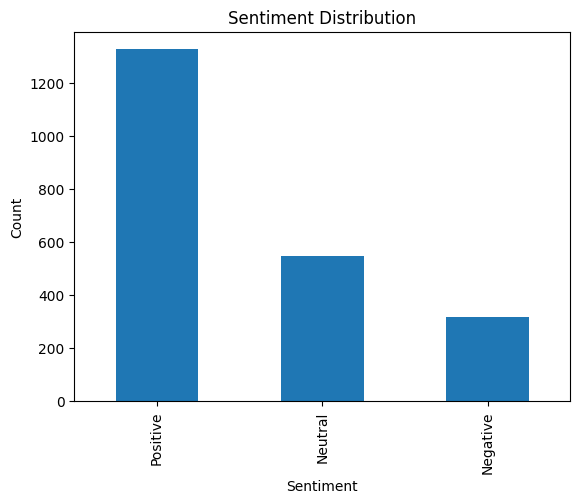

In [25]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [26]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')


# Monthly Employee Sentiment Scoring

In [27]:
sentiment_score = {
    "Positive": 1,
    "Negative": -1,
    "Neutral": 0
}

df['score'] = df['sentiment'].map(sentiment_score)

monthly_scores = df.groupby(['from', 'month'])['score'].sum().reset_index()
monthly_scores.head()


,from,month,score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,10
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,3


# Employee Ranking

In [28]:
top_positive = monthly_scores.sort_values(
    ['month', 'score', 'from'],
    ascending=[True, False, True]
).groupby('month').head(3)

top_negative = monthly_scores.sort_values(
    ['month', 'score', 'from'],
    ascending=[True, True, True]
).groupby('month').head(3)

top_positive, top_negative


(                            from    month  score
 120      kayne.coulter@enron.com  2010-01     13
 24        don.baughman@enron.com  2010-01      6
 48           eric.bass@enron.com  2010-01      6
 1    bobette.riner@ipgdirect.com  2010-02     10
 73         john.arnold@enron.com  2010-02      9
 ..                           ...      ...    ...
 190     patti.thompson@enron.com  2011-11      9
 142      kayne.coulter@enron.com  2011-11      7
 143      kayne.coulter@enron.com  2011-12      6
 191     patti.thompson@enron.com  2011-12      6
 215      rhonda.denton@enron.com  2011-12      6
 
 [72 rows x 3 columns],
                             from    month  score
 192      rhonda.denton@enron.com  2010-01      0
 0    bobette.riner@ipgdirect.com  2010-01      2
 72         john.arnold@enron.com  2010-01      3
 217         sally.beck@enron.com  2010-02     -1
 145      lydia.delgado@enron.com  2010-02      1
 ..                           ...      ...    ...
 214      rhonda.denton@

# Flight Risk Identification

In [33]:
# Flight Risk Identification (Rolling 30-Day Window)

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['negative_flag'] = (df['sentiment'] == 'Negative').astype(int)

df = df.sort_values(['from', 'date'])

rolling_30d = (
    df
    .set_index('date')
    .groupby('from')['negative_flag']
    .rolling('30D')
    .sum()
    .reset_index()
)

df = df.merge(
    rolling_30d,
    on=['from', 'date'],
    how='left',
    suffixes=('', '_30d')
)

flight_risk = (
    df[df['negative_flag_30d'] >= 4][['from']]
    .drop_duplicates()
    .reset_index(drop=True)
)

flight_risk




,from
0,bobette.riner@ipgdirect.com
1,don.baughman@enron.com
2,eric.bass@enron.com
3,john.arnold@enron.com
4,johnny.palmer@enron.com
5,lydia.delgado@enron.com
6,patti.thompson@enron.com
7,rhonda.denton@enron.com
8,sally.beck@enron.com


# Predictive Modeling

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = monthly_scores.copy()
features['month_num'] = features['month'].astype(str).str.replace('-', '').astype(int)

X = features[['month_num']]
y = features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)


-0.09179556541614442

## Final Observations

- Overall employee sentiment shows mixed trends.
- Certain employees consistently display negative sentiment and may be at flight risk.
- Sentiment trends can be moderately modeled using simple regression.
- This analysis can help HR proactively address employee engagement.
